# Quantum Convolutional Neural Network 

## <ins> Convolutional Architecture Building blocks <ins>

In this section, we design and test each part of the QCNN in comparison with PennyLane simulation to ensure the good simulation of the results.

In [1]:
import torch
from torch import nn
from scipy.special import binom
import matplotlib.pyplot as plt

from PennyLane_toolbox import *
from toolbox import *

### <font color='red'>Conv Layer:</font>

We first start with the convolution layer.

In [2]:
from Conv_Layer import *

Let's define a common initial state that we can use to test our Pytorch simulation:

In [3]:
n, k = 8, 2
# Filter size:
K = 4

dev = qml.device("default.qubit", wires=n)

@qml.qnode(dev)
def circuit(angle):
    qml.PauliX(wires=0)
    qml.PauliX(wires=4)
    RBS(0,1, angle)
    RBS(4,5, angle)
    return qml.state()

# We express the final state in the basis of Hamming weight k:
map = map_RBS(n,k)
initial_state = map_Computational_Basis_to_HW_Subspace(n,k,map,torch.tensor(circuit(torch.pi/4)))
initial_rho = torch.einsum('i,j->ij', initial_state, initial_state)
print("Initial state in the Hamming weight basis:")
print(initial_state)
# We express the final state in the Image basis:
map_I2 = map_RBS_I2_2D(n//2)
print("Initial state in the Image basis:")
initial_state_I2 = map_Computational_Basis_to_Image_Square_Subspace(n,map_I2,torch.tensor(circuit(torch.pi/4)))
initial_rho_I2 = torch.einsum('i,j->ij', initial_state_I2, initial_state_I2)
print(initial_state_I2)

Initial state in the Hamming weight basis:
tensor([ 0.0000,  0.0000,  0.0000,  0.5000, -0.5000,  0.0000,  0.0000,  0.0000,
         0.0000, -0.5000,  0.5000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000])
Initial state in the Image basis:
tensor([ 0.5000, -0.5000,  0.0000,  0.0000, -0.5000,  0.5000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])


We can now test our convolutional layer <ins>__using Pytorch__<ins>:

In [4]:
# Hardware accelerator:
device = torch.device("cpu")  # Only using CPU

### Pytorch simulation:
CONV = Conv_RBS_state_vector(n//2,K,device)
CONV_I2 = Conv_RBS_state_vector_I2(n//2,K,device)
out_1 = CONV.forward(initial_state.unsqueeze(0)) # Unsqueeze to add batch dimension
out_2 = CONV_I2.forward(initial_state_I2.unsqueeze(0)) # Unsqueeze to add batch dimension
print(out_1)
print(out_2)

tensor([[ 0.0000,  0.0000,  0.0000, -0.0077, -0.0189,  0.0272, -0.0043,  0.0000,
          0.0000, -0.0138, -0.0336,  0.0485, -0.0077,  0.0000, -0.2109, -0.5149,
          0.7430, -0.1180,  0.0779,  0.1902, -0.2745,  0.0436,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000]], grad_fn=<SqueezeBackward1>)
tensor([[ 0.1543,  0.1187, -0.1347,  0.0109, -0.2823, -0.2171,  0.2465, -0.0200,
         -0.5382, -0.4139,  0.4698, -0.0381,  0.1755,  0.1350, -0.1532,  0.0124]],
       grad_fn=<SqueezeBackward1>)


And <ins>__using Pennylane__<ins>:

Considering state simulations:

In [5]:
### PennyLane simulation:
# We extract the parameters from the Pytorch model:
angles = [float(CONV.Parameters[i]) for i in range(len(CONV.Parameters))]
angles_I2 = [float(CONV_I2.Parameters[i]) for i in range(len(CONV_I2.Parameters))]
# We define again the circuit:
Param_dictionnary, list_gates = Conv_2D_gates([i for i in range(n)], K)
@qml.qnode(dev)
def Circuit_global(angles):
    qml.PauliX(wires=0)
    qml.PauliX(wires=4)
    RBS(0,1, torch.pi/4)
    RBS(4,5, torch.pi/4)
    Conv_RBS_2D(angles, Param_dictionnary, list_gates)
    return qml.state()

print(torch.sum(map_Computational_Basis_to_HW_Subspace(n,k,map,torch.tensor(Circuit_global(angles))) - out_1))
print(torch.sum(map_Computational_Basis_to_Image_Square_Subspace(n,map_I2,torch.tensor(Circuit_global(angles_I2))) - out_2))

tensor(2.2352e-08, grad_fn=<SumBackward0>)
tensor(-2.2072e-07, grad_fn=<SumBackward0>)


Considering density matrix simulation:

In [6]:
### Pytorch simulation:
CONV = Conv_RBS_density(n//2,K,device)
CONV_I2 = Conv_RBS_density_I2(n//2,K,device)
out_1 = CONV.forward(initial_rho.unsqueeze(0)) # Unsqueeze to add batch dimension
out_2 = CONV_I2.forward(initial_rho_I2.unsqueeze(0)) # Unsqueeze to add batch dimension

### PennyLane simulation:
# We extract the parameters from the Pytorch model:
angles = [float(CONV.Parameters[i]) for i in range(len(CONV.Parameters))]
angles_I2 = [float(CONV_I2.Parameters[i]) for i in range(len(CONV_I2.Parameters))]
# We define again the circuit:
Param_dictionnary, list_gates = Conv_2D_gates([i for i in range(n)], K)
@qml.qnode(dev)
def Circuit_global_density(angles):
    qml.PauliX(wires=0)
    qml.PauliX(wires=4)
    RBS(0,1, torch.pi/4)
    RBS(4,5, torch.pi/4)
    Conv_RBS_2D(angles, Param_dictionnary, list_gates)
    return qml.density_matrix([i for i in range(n)])

print(torch.sum(torch.abs(map_Computational_Basis_to_HW_Subspace_density(n,k,map,torch.tensor(Circuit_global_density(angles)))-out_1)))
print(torch.sum(torch.abs(map_Computational_Basis_to_Image_Square_Subspace_density(n,map_I2,torch.tensor(Circuit_global_density(angles_I2)))-out_2)))

tensor(1.1906e-06, grad_fn=<SumBackward0>)


tensor(1.5569e-06, grad_fn=<SumBackward0>)


### <font color='red'>Dense Layer:</font>

We now study the simulation of the Dense Layer. We will use the same initial state than for the Convolutional layer section.

In [7]:
from Dense import *

In [8]:
# Hardware accelerator:
device = torch.device("cpu")  # Only using CPU

# Dense layer definition:
list_gates = [(i,i+1) for i in range(n-1)]

### Pytorch simulation:
Dense = Dense_RBS_state_vector(n//2,list_gates,device)
Dense_density = Dense_RBS_density(n//2,list_gates,device)

We define the equivalent Pennylane simulation:

In [9]:
@qml.qnode(dev)
def Circuit_global(angles):
    qml.PauliX(wires=0)
    qml.PauliX(wires=4)
    RBS(0,1, torch.pi/4)
    RBS(4,5, torch.pi/4)
    dense_RBS(angles, list_gates)
    return qml.state()

@qml.qnode(dev)
def Circuit_global_density(angles):
    qml.PauliX(wires=0)
    qml.PauliX(wires=4)
    RBS(0,1, torch.pi/4)
    RBS(4,5, torch.pi/4)
    dense_RBS(angles, list_gates)
    return qml.density_matrix([i for i in range(n)])

# We extract the parameters from the Pytorch model:
angles = [float(Dense.RBS_gates[i].angle) for i in range(len(Dense.RBS_gates))]
angles_density = [float(Dense_density.RBS_gates[i].angle) for i in range(len(Dense_density.RBS_gates))]

out_1 = Dense.forward(initial_state.unsqueeze(0)) # Unsqueeze to add batch dimension
out_2 = Dense_density.forward(initial_rho.unsqueeze(0)) # Unsqueeze to add batch dimension
print(torch.sum(torch.abs(map_Computational_Basis_to_HW_Subspace(n,k,map,torch.tensor(Circuit_global(angles))) - out_1)))
print(torch.sum(torch.abs(map_Computational_Basis_to_HW_Subspace_density(n,k,map,torch.tensor(Circuit_global_density(angles_density))) - out_2)))

tensor(9.4238e-08, grad_fn=<SumBackward0>)
tensor(2.3563e-07, grad_fn=<SumBackward0>)


### <font color='red'>Pooling Layer:</font>

We now study the simulation of the Pooling Layer

In [10]:
from Pooling import *

We can now test our pooling layer <ins>__using Pytorch__<ins>:

In [11]:
# Hardware accelerator:
device = torch.device("cpu")  # Only using CPU

### Pytorch simulation:
model = nn.Sequential(Conv_RBS_state_vector_I2(n//2,4,device),Pooling_2D_state_vector(n//2,n//4,device))
out_model = model(initial_state_I2)
print(out_model)

RuntimeError: einsum(): the number of subscripts in the equation (2) does not match the number of dimensions (1) for operand 0 and no ellipsis was given

/home/leo/anaconda3/envs/Quantum/lib/python3.9/_collections_abc.py:856: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/leo/anaconda3/envs/Quantum/lib/python3.9/_collections_abc.py:856: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/leo/anaconda3/envs/Quantum/lib/python3.9/_collections_abc.py:856: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/leo/anaconda3/envs/Quantum/lib/python3.9/_collections_abc.py:856: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/leo/anaconda3/envs/Quantum/lib/python3

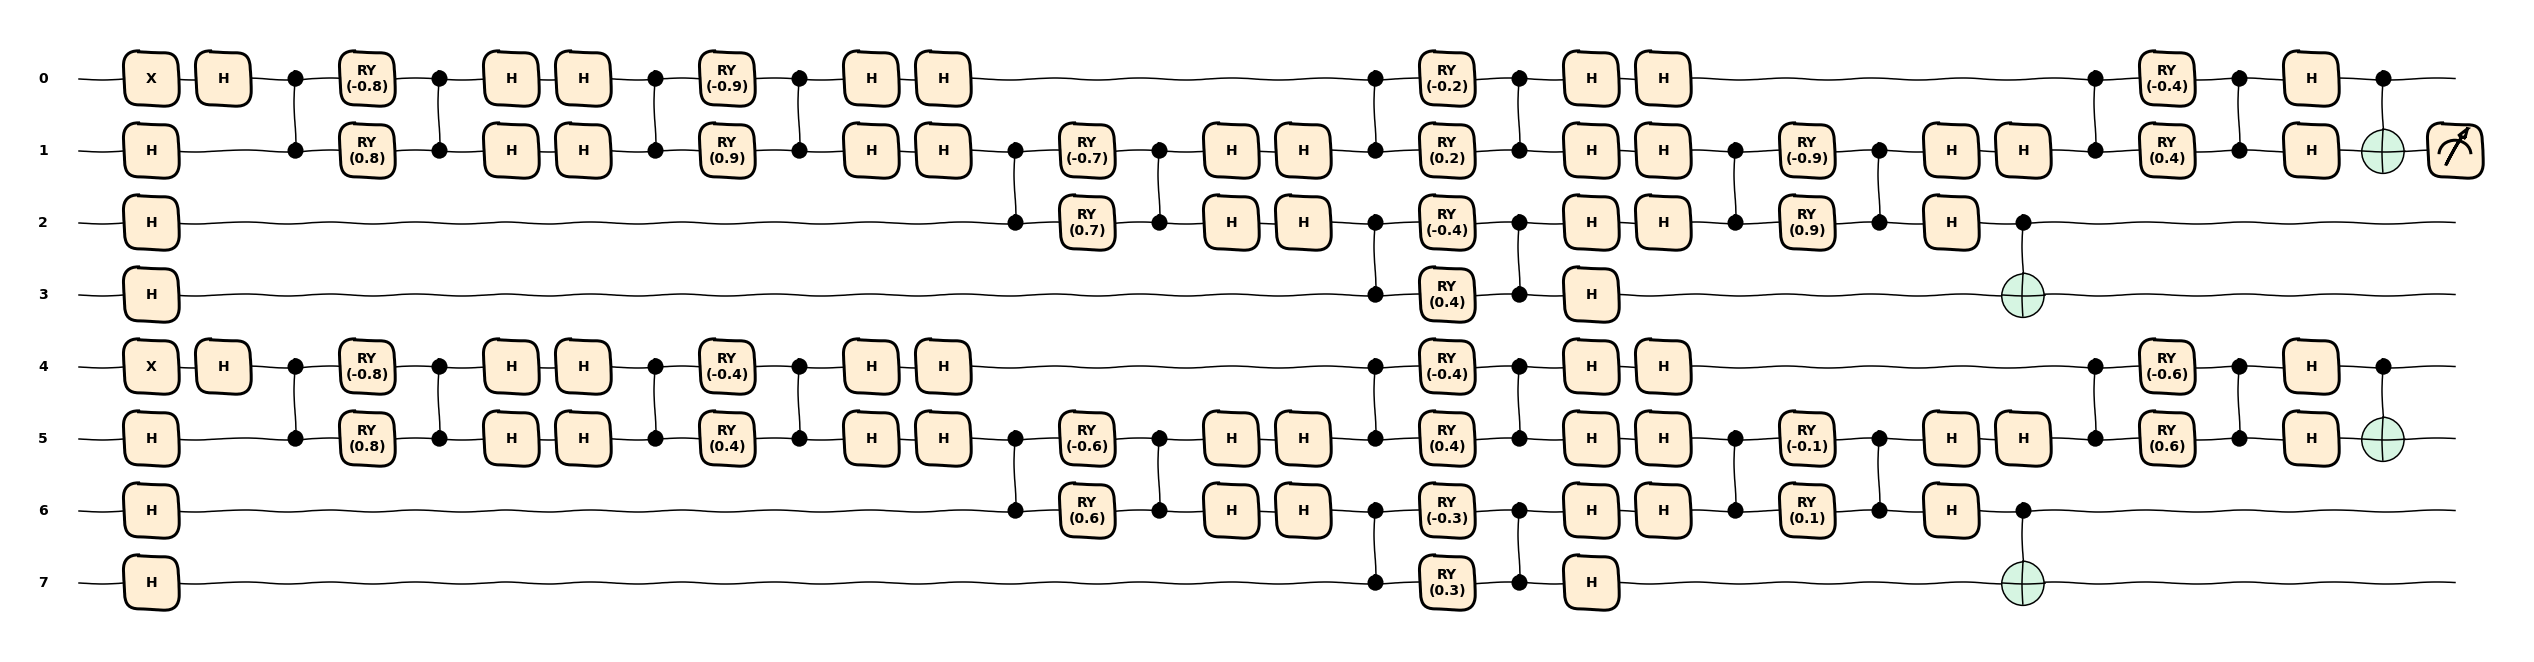

In [ ]:
qnode = qml.QNode(Circuit_global, dev)
qml.draw_mpl(qnode, decimals=1, style="sketch")(angles)
plt.show()

Let's derive the probability to have the qubit 1 in state |0>. The order of the basis chosen is such that the first I elements of each state correspond to the state where the first qubit is in state |1>. Therefore:

In [ ]:
# The first value correspond to the proba to have qubit 1 in state 0, and the second value to have qubit 1 in state 1
proba_1 = sum([out_model[i][j]**2 for i in range(out_model.shape[0]) for j in range(2)])
proba_0 = 1 - proba_1
print(proba_0, proba_1)

tensor(0.9315, grad_fn=<RsubBackward1>) tensor(0.0685, grad_fn=<AddBackward0>)


Let's do the same simulation using PennyLane:

In [ ]:
### PennyLane simulation:
torch_parameters = list(model[0].parameters())
angles = [float(torch_parameters[i]) for i in range(len(torch_parameters))]

@qml.qnode(dev)
def Circuit_global(angles):
    qml.PauliX(wires=0)
    qml.PauliX(wires=4)
    RBS(0,1, torch.pi/4)
    RBS(4,5, torch.pi/4)
    Conv_RBS_2D(angles, Param_dictionnary, list_gates)
    Pool_2D([i for i in range(n)])
    return qml.probs(1)

print(Circuit_global(angles))

[0.93152912 0.06847088]
